## Artist Investments vs. Streaming Success  
### Introduction

The recorded music industry has undergone radical changes in the past two decades, with per-listen royalties replacing revenue from physical media and paid downloads. This transition dramatically reduced artist income while competition from exploding content catalogs increased.

This project explores the effectiveness of different artist investments in driving streaming performance, attempting to quantify how spending on production and promotion is associated with differing stream counts. The aim is guide artists towards prioritizing costs that provide a measurable return.

### Data Exploration

We'll explore/clean the streaming data and survey responses to produce summary statistics and visual diagnostics for the key variables used in the regression analysis.

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import statsmodels.formula.api as smf
from statsmodels.iolib.summary2 import summary_col
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='notebook')

In [2]:
streams = pd.read_csv('../data/streaming_data_anonymized.csv')

# Drop two artists due to unreplicable distribution methods
streams = streams[~streams['artist'].isin(["Artist_006", "Artist_039"])]
streams.sample(5)

,artist,quantity,platform,price,rev,type,date
75608,Artist_011,1.0,GOOGLE,0.009142,0.009142,STREAM,2020-04-30
154987,Artist_027,2.0,APPLE MUSIC,0.000037,0.000074,STREAM,2020-06-30
130036,Artist_027,5.0,APPLE MUSIC,0.009964,0.049818,STREAM,2020-03-31
95358,Artist_013,1.0,SPOTIFY,0.001772,0.001772,STREAM,2020-05-31
9925,Artist_004,1.0,APPLE MUSIC,0.000170,0.000170,STREAM,2020-05-31


In [3]:
# type column implies there could be more than STREAM data. Let's inspect
streams.type.value_counts()

type
STREAM      168837
DOWNLOAD      1055
YOUTUBE        435
ROYALTY        143
Name: count, dtype: int64

In [4]:
# let's filter for only streams
streams = streams[streams['type'] == "STREAM"]
streams.info()

<class 'pandas.core.frame.DataFrame'>
Index: 168837 entries, 0 to 192998
Data columns (total 7 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   artist    168837 non-null  object 
 1   quantity  168837 non-null  float64
 2   platform  168837 non-null  object 
 3   price     168837 non-null  float64
 4   rev       168837 non-null  float64
 5   type      168837 non-null  object 
 6   date      168837 non-null  object 
dtypes: float64(3), object(4)
memory usage: 10.3+ MB


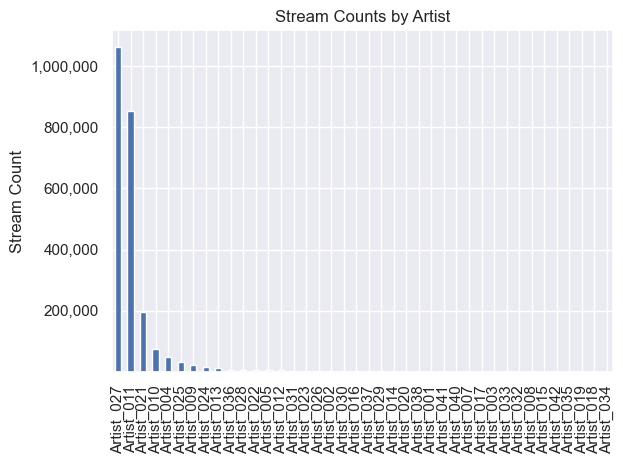

In [5]:
# inspect stream count by artist
streams_by_artist = streams.groupby("artist")["quantity"].sum().sort_values(ascending=False)

ax = streams_by_artist.plot.bar()
ax.set(ylabel="Stream Count", xlabel="", title="Stream Counts by Artist")
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x):,}' if x >= 1 else ''))
plt.tight_layout()
plt.show()

This looks lognormally distributed towards a couple of dominant artists. Let's confirm...

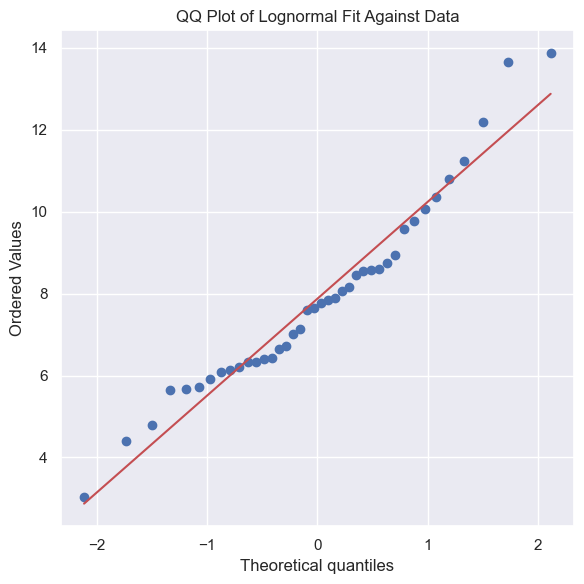

In [6]:
log_streams = np.log1p(streams_by_artist.values)

fig = plt.figure(figsize=(6, 6))
ax_qq = fig.add_subplot(111)
stats.probplot(log_streams, dist="norm", plot=ax_qq)
ax_qq.set_title("QQ Plot of Lognormal Fit Against Data")
plt.tight_layout()
plt.show()

The QQ plot confirms that stream counts are approximately lognormally distributed, meaning most artists receive relatively few streams while a small number achieve disproportionately high counts.

In [7]:
survey = pd.read_csv('../data/survey_responses_anonymized.csv')

# Drop two artists due to highly-abnormal distribution methods
survey = survey[~survey['artist'].isin(["Artist_006", "Artist_039"])]
survey.head()

,artist,continent,genre,vocals,years_since_most_active,tour_cities,covers,add_content,prod_cost,art_cost,videos,pr,ad_spend,num_albums,singles_eps,num_titles,years_active,videos_hq,label
0,Artist_041,North America,Jazz,0,4,10,1,0,800,500,7,0,1200,1,0,1,1,0,0
1,Artist_037,North America,Funk,0,4,25,0,0,3000,0,12,0,1500,1,0,1,1,4,0
2,Artist_034,North America,Pop,1,1,1,0,0,300,0,0,0,100,0,1,1,1,0,0
3,Artist_010,North America,Jazz,1,1,30,1,0,5790,300,20,2,500,2,7,9,6,7,0
4,Artist_025,North America,Folk/Americana,1,3,161,1,0,12000,100,273,3,5000,4,7,11,8,14,0


In [8]:
# lots of data, fast-forward to the important columns and inspect summary stats
survey = survey[['artist', 'prod_cost', 'pr', 'ad_spend', 'num_albums', 'singles_eps', 'videos_hq', 'label']]

# scale prod cost in thousands, ad cost in hundreds
survey["prod_cost"] = survey["prod_cost"] / 1000
survey["ad_spend"] = survey["ad_spend"] / 100

# join stream count to survey data
df = survey.merge(streams_by_artist.rename("stream_count"), left_on="artist", right_index=True, how="left")

# let's see summary stats
df.drop("label", axis=1).describe().loc[['count', 'mean', 'std', 'min', '50%', 'max']].round(3)

,prod_cost,pr,ad_spend,num_albums,singles_eps,videos_hq,stream_count
count,40.000,40.000,40.000,40.000,40.000,40.000,40.000
mean,4.917,1.175,6.626,3.100,1.575,2.025,59668.075
std,4.256,1.174,20.191,3.249,2.836,3.445,212641.441
min,0.000,0.000,0.000,0.000,0.000,0.000,20.000
50%,3.750,1.000,1.000,2.000,0.000,0.000,2241.000
max,18.000,4.000,120.000,19.000,12.000,14.000,1062833.000


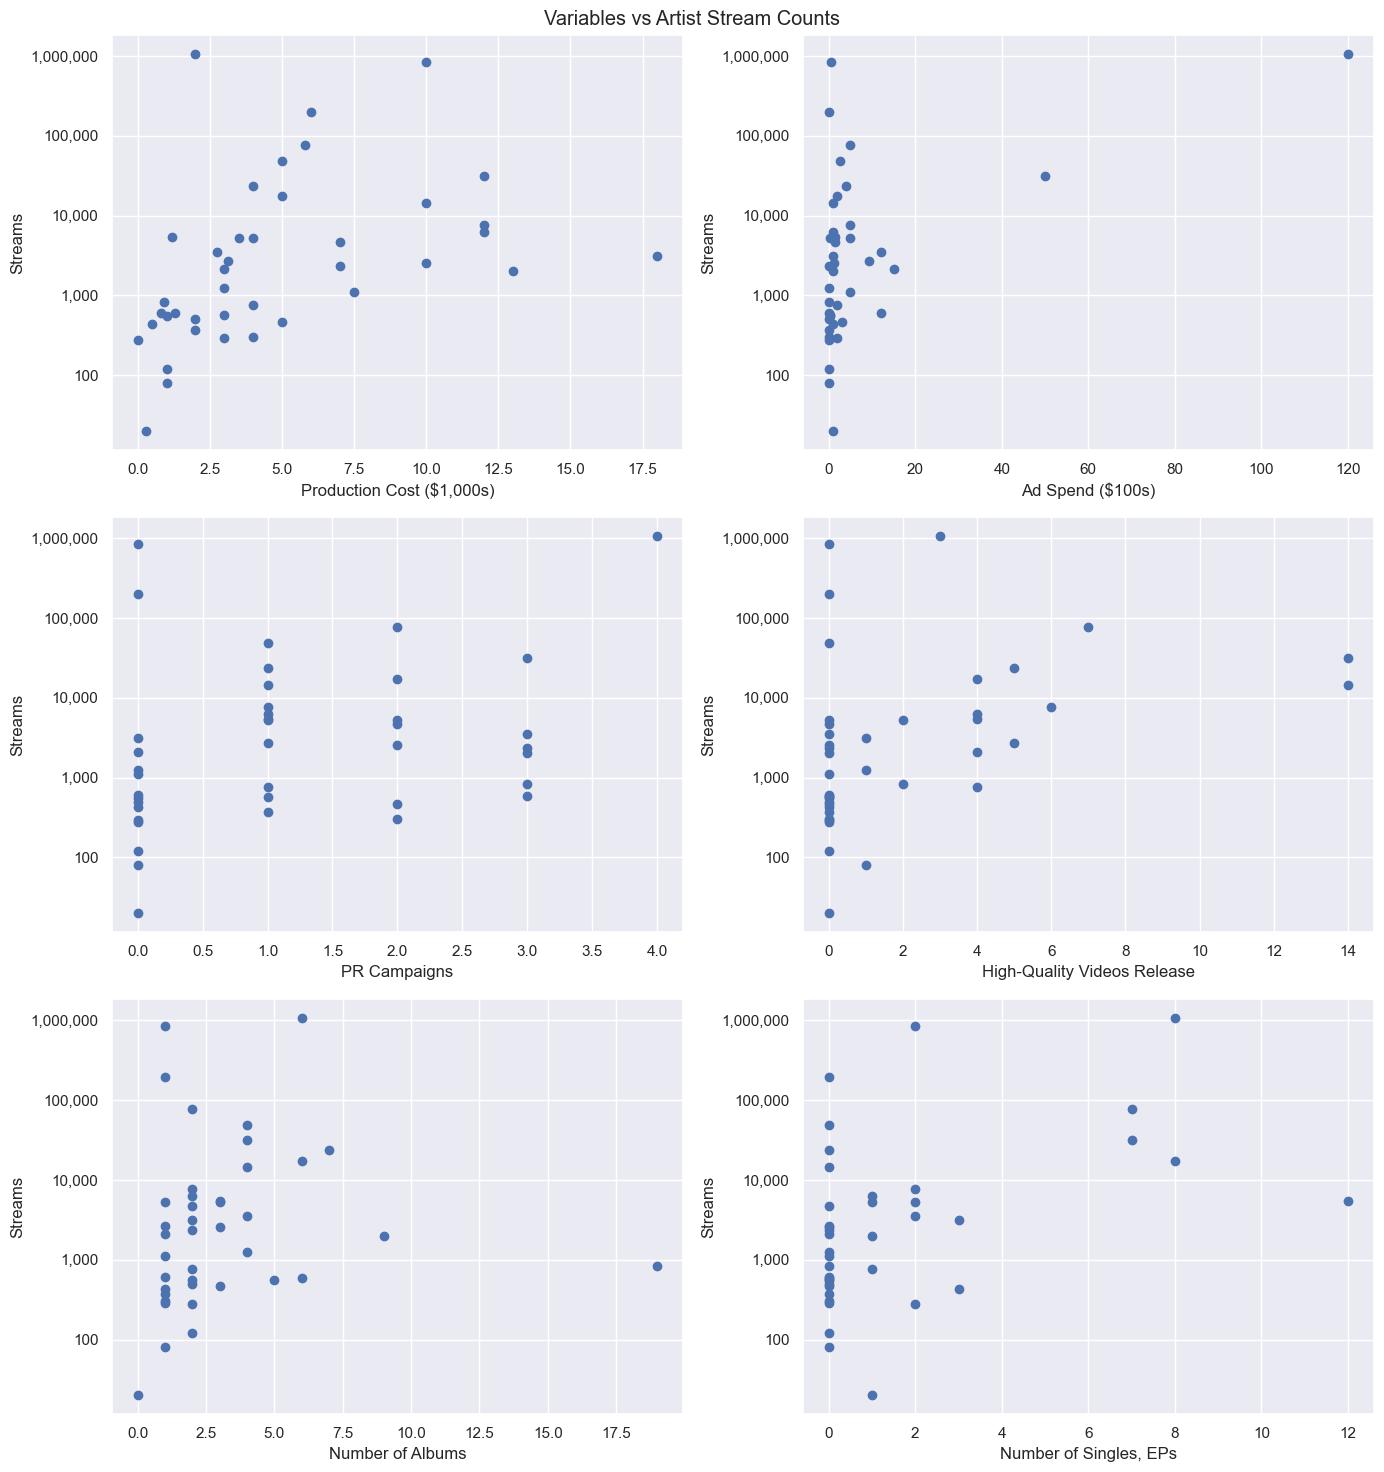

In [9]:
# let's visualize the relationship between investments, output, and stream counts
fig, axes = plt.subplots(3, 2, figsize=(14, 15))
features = ['prod_cost', 'ad_spend', 'pr', 'videos_hq', 'num_albums','singles_eps']
titles = ['Production Cost ($1,000s)', 'Ad Spend ($100s)', 'PR Campaigns', 'High-Quality Videos Release', 'Number of Albums','Number of Singles, EPs']

for ax, feature, title in zip(axes.flatten(), features, titles):
    ax.scatter(df[feature], df['stream_count'])
    ax.set_yscale('log')
    ax.set_ylabel('Streams')
    ax.set_xlabel(title)
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x):,}'))

plt.suptitle('Variables vs Artist Stream Counts')
plt.tight_layout()
plt.show()

The scatterplots reveal a potential nonlinear relationship between production cost and stream counts, and two potentially high-leverage outliers in ad spending. Other variables such as PR campaigns, HQ video releases, and catalog size show weaker or more diffuse relationships with streaming performance.


### Modeling

We estimate a series of OLS regressions to investigate the relationship between artist investments and streaming performance. The dependent variable is the natural log of stream counts. The primary independent variables include production cost (with a squared term), PR campaigns, ad spend, number of HQ videos, and catalog size controls. Label affiliation is treated as a binary categorical variable.


In [10]:
# Create modeling variables
df["log_streams"] = np.log(df["stream_count"])
df["prod_cost_sq"] = df["prod_cost"] ** 2

# Define models specs
formulas = {
    "model1": "log_streams ~ prod_cost + num_albums + singles_eps + label",
    "model2": "log_streams ~ prod_cost + prod_cost_sq + num_albums + singles_eps + label",
    "model3": "log_streams ~ prod_cost + prod_cost_sq + ad_spend + pr + num_albums + singles_eps + label",
    "model4": "log_streams ~ prod_cost + prod_cost_sq + ad_spend + pr + videos_hq + num_albums + singles_eps + label",
    "model5": "log_streams ~ prod_cost + prod_cost_sq + ad_spend + pr + num_albums + singles_eps"
}

# Run models on full data
results_full = {name: smf.ols(formula, data=df).fit() for name, formula in formulas.items()}

# Exclude two ad spend outliers, re-run model 5 on trimmed data
df_trimmed = df[df["ad_spend"] < 40]
results_trimmed = smf.ols(formulas["model5"], data=df_trimmed).fit()

all_models = list(results_full.values())[:] + [results_trimmed]
model_names = ["(1)", "(2)", "(3)", "(4)", "(5)", "(6)¹"]

# Summary table
results_table = summary_col(
    results=all_models,
    float_format="%0.3f",
    stars=True,
    model_names=model_names,
    info_dict={
        "N": lambda x: f"{int(x.nobs)}",
        "SER": lambda x: f"{np.sqrt(x.mse_resid):.3f}"
    },
    regressor_order=[
        "prod_cost", "prod_cost_sq", "ad_spend", "pr", "videos_hq",
        "num_albums", "singles_eps", "label", "Intercept"
    ]
)

print(results_table)
print("¹ Model 6 excludes two high-leverage ad spend outliers.")
print("\nThe adjusted R² and standard error of regression (SER) indicate overall model fit.\nCoefficients can be interpreted approximately as percent changes in stream counts for unit changes in each variable.")



                 (1)       (2)       (3)       (4)       (5)       (6)¹  
-------------------------------------------------------------------------
prod_cost      0.219*** 0.909***  1.090***  1.159***  1.085***  1.113*** 
               (0.072)  (0.191)   (0.190)   (0.206)   (0.195)   (0.194)  
prod_cost_sq            -0.047*** -0.057*** -0.060*** -0.057*** -0.057***
                        (0.012)   (0.012)   (0.013)   (0.012)   (0.012)  
ad_spend                          0.045***  0.048***  0.050***  0.079    
                                  (0.015)   (0.015)   (0.015)   (0.066)  
pr                                -0.668**  -0.715**  -0.639**  -0.618** 
                                  (0.299)   (0.305)   (0.307)   (0.303)  
videos_hq                                   -0.073                       
                                            (0.083)                      
num_albums     0.006    0.024     0.143     0.160     0.184*    0.186*   
               (0.102)  (0.086)   (0.

### Results & Conclusion

- Production spending showed the strongest and most consistent positive association with streaming activity across all models, with evidence of diminishing returns above ~$9,500

- Social media ad spend was also positively associated with stream counts, though its significance declined when extreme outliers were excluded.

- PR campaigns were negatively associated with stream counts in every specification, while high-quality video releases and label affiliation had no measurable effect, suggesting that traditional promotional tools may be less effective in a streaming-first landscape.

- Releasing singles and EPs was more strongly associated with higher stream counts than releasing full-length albums, supporting a strategy of frequent, smaller releases.

- Due to the data's concentration in jazz/instrumental genres, geographic skew, and reliance on self-reported data, these findings are not broadly generalizable. Still, they offer directional insight into effective investment strategies for artists.